In [1]:
import time
import os
import random
import numpy as np                                                
import matplotlib.pyplot as plt                                   
import autograd, autograd.core, autograd.extend, autograd.tracer  
import autograd.numpy as anp      
import scipy, scipy.ndimage, scipy.sparse, scipy.sparse.linalg    
                                                     
import gym
# from gym import spaces
from gymnasium import spaces
import gymnasium 

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter

In [32]:
# !pip3 install --upgrade stable_baselines3
# !pip3 install gym==0.22.0 

The below code is my RL extension to and rework of https://www.researchgate.net/publication/360698153_A_Tutorial_on_Structural_Optimization 
and
https://www.sciencedirect.com/science/article/pii/S0264127522002933

In [3]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_args(normals, forces, density=1e-4):  # Manage the problem setup parameters
    width = normals.shape[0] - 1
    height = normals.shape[1] - 1
    fixdofs = np.flatnonzero(normals.ravel())
    alldofs = np.arange(2 * (width + 1) * (height + 1))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
    params = {
      # material properties
      'young': 1, 'young_min': 1e-9, 'poisson': 0.3, 'g': 0,
      # constraints
      'density': density, 'xmin': 0.001, 'xmax': 1.0,
      # input parameters
      'nelx': width, 'nely': height, 'mask': 1, 'penal': 3.0, 'filter_width': 1,
      'freedofs': freedofs, 'fixdofs': fixdofs, 'forces': forces.ravel(),
      # optimization parameters
      'opt_steps': 80, 'print_every': 10}
    return ObjectView(params)

def mbb_beam(width=6, height=6, density=1e-4, y=1, x=0, rd=-1):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    normals[0, 0, x] = 1
    normals[0, 0, y] = 1
    normals[0, -1, x] = 1
    normals[0, -1, y] = 1
    forces = np.zeros((width + 1, height + 1, 2))
    forces[-1, rd, y] = -1
    return normals, forces, density

In [4]:
def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x, args, volume_contraint=False, use_filter=True):
    x = args.mask * x.reshape(args.nely, args.nelx)  # reshape from 1D to 2D
    return gaussian_filter(x, args.filter_width) if use_filter else x  # maybe filter

def mean_density(x, args, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, args, volume_contraint, use_filter)) / anp.mean(args.mask)

In [5]:
def objective(x, args, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=args.penal, e_min=args.young_min, e_0=args.young)
    x_phys = physical_density(x, args, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(args.young, args.poisson)  # stiffness matrix
    u      = displace(x_phys, ke, args.forces, args.freedofs, args.fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

In [6]:
@autograd.extend.primitive
def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')

def _gaussian_filter_vjp(ans, x, width): # gives the gradient of orig. function w.r.t. x
    del ans, x  # unused
    return lambda g: gaussian_filter(g, width)
autograd.extend.defvjp(gaussian_filter, _gaussian_filter_vjp)

In [7]:
def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])

In [8]:
def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)

    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]

In [9]:
def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm

In [10]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
    return scipy.sparse.linalg.splu(a).solve

@autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp

autograd.extend.defvjp(solve_coo, grad_solve_coo_entries,
                       lambda: print('err: gradient undefined'),
                       lambda: print('err: gradient not implemented'))

In [11]:
class Model:
    def __init__(self, x):
        self.flag_ = True
#         self.flag_ = False
        self.n, self.m = x.shape
        self.actions_dic={} 
    
        k=0
        for i in range(self.n):
            for j in range(self.m):
                self.actions_dic[k]=(i,j)
                k+=1
        
    def action_space_(self, action, X):
        x,y=self.actions_dic[action]
        X[x][y]=1
        
    def draw(self,X):  
        plt.figure(dpi=50) 
        print('\nFinal Cantilever beam design:')
        plt.imshow(X) 
        plt.show()

In [12]:
def fast_stopt(args, x):

    reshape = lambda x: x.reshape(args.nely, args.nelx)
    objective_fn = lambda x: objective(reshape(x), args)
#     constraint = lambda params: mean_density(reshape(params), args) - args.density
    constraint = lambda params: mean_density(reshape(params), args) 
    value = objective_fn(x)
    const = constraint(x)
    return value, const

In [13]:
class CantileverEnv(gym.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self):
        super().__init__()
        
        
        self.rd=0
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        DIM=self.args.nelx*self.args.nely
        N_DISCRETE_ACTIONS=self.args.nelx*self.args.nely
        
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=np.array([-1e10 for x in range(DIM)]),
                                            high=np.array([1e10 for y in range(DIM)]),
                                            shape=(DIM,),
                                           dtype=np.float64)
        
 
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 
    
        self.M=Model(self.x)
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
#         self.seed=0
        
    def step(self, action):
        
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        self.M.action_space_(action, self.x)
        
        self.tmp, self.const = fast_stopt(self.args, self.x)
#         print(tmp, const)
        
        self.step_+=1
        
        self.reward+=(1/self.tmp)**2
       
        done=False
                  
        if self.step_>self.M.n*self.M.m:
            done=True
            
        if self.const>0.7:
#             self.reward-=1
            done=True
            
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
                         
      
        return self.x.reshape(self.x.shape[0]*self.x.shape[1]), self.reward, done,False, dict()

    def reset(self,seed=0):
        
        if not self.M.flag_:
            self.rd=random.choice([0,2,-2])
        else:
            self.rd=-1
           
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 

        self.reward=0
        self.needs_reset = False
        self.step_=0

        return self.x.reshape(self.x.shape[0]*self.x.shape[1]),{}

    def render(self, mode="human"):
        self.M.draw(self.x)    

    def close(self):
        pass

In [14]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [15]:
# ts=5e6
ts=1e6

In [16]:
# Create log dir
log_dir = "/tmp/gym6/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = CantileverEnv()
# Logs will be saved in log_dir/monitor.csv

env = Monitor(env, log_dir)
check_env(env)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_mode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_mode` for environment variables or `env.get_wrapper_attr('render_mode')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:74: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  try:


In [17]:
# callback = SaveOnBestTrainingRewardCallback(check_freq=5000, log_dir=log_dir)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

In [18]:
start=time.time()
model = PPO("MlpPolicy", env).learn(total_timesteps=ts, callback=callback)
end=time.time()   

Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 2000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 3000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 10000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 11000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 12000
Best mean reward: 0.01 - Last mean reward per e

Num timesteps: 88000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 89000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 90000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 91000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 92000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 93000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 94000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 95000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 96000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 97000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Saving new best model to /tmp/gym6/best_

Num timesteps: 164000
Best mean reward: 0.14 - Last mean reward per episode: 0.14
Num timesteps: 165000
Best mean reward: 0.14 - Last mean reward per episode: 0.14
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 166000
Best mean reward: 0.14 - Last mean reward per episode: 0.14
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 167000
Best mean reward: 0.14 - Last mean reward per episode: 0.15
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 168000
Best mean reward: 0.15 - Last mean reward per episode: 0.15
Num timesteps: 169000
Best mean reward: 0.15 - Last mean reward per episode: 0.14
Num timesteps: 170000
Best mean reward: 0.15 - Last mean reward per episode: 0.14
Num timesteps: 171000
Best mean reward: 0.15 - Last mean reward per episode: 0.15
Num timesteps: 172000
Best mean reward: 0.15 - Last mean reward per episode: 0.15
Num timesteps: 173000
Best mean reward: 0.15 - Last mean reward per episode: 0.15
Saving new best model to /tmp/

Num timesteps: 238000
Best mean reward: 0.23 - Last mean reward per episode: 0.23
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 239000
Best mean reward: 0.23 - Last mean reward per episode: 0.23
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 240000
Best mean reward: 0.23 - Last mean reward per episode: 0.23
Num timesteps: 241000
Best mean reward: 0.23 - Last mean reward per episode: 0.23
Num timesteps: 242000
Best mean reward: 0.23 - Last mean reward per episode: 0.22
Num timesteps: 243000
Best mean reward: 0.23 - Last mean reward per episode: 0.23
Num timesteps: 244000
Best mean reward: 0.23 - Last mean reward per episode: 0.23
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 245000
Best mean reward: 0.23 - Last mean reward per episode: 0.24
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 246000
Best mean reward: 0.24 - Last mean reward per episode: 0.24
Saving new best model to /tmp/gym6/best_model.zip
Num timestep

Num timesteps: 323000
Best mean reward: 0.31 - Last mean reward per episode: 0.31
Num timesteps: 324000
Best mean reward: 0.31 - Last mean reward per episode: 0.31
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 325000
Best mean reward: 0.31 - Last mean reward per episode: 0.31
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 326000
Best mean reward: 0.31 - Last mean reward per episode: 0.31
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 327000
Best mean reward: 0.31 - Last mean reward per episode: 0.31
Num timesteps: 328000
Best mean reward: 0.31 - Last mean reward per episode: 0.31
Num timesteps: 329000
Best mean reward: 0.31 - Last mean reward per episode: 0.31
Num timesteps: 330000
Best mean reward: 0.31 - Last mean reward per episode: 0.31
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 331000
Best mean reward: 0.31 - Last mean reward per episode: 0.31
Saving new best model to /tmp/gym6/best_model.zip
Num timestep

Num timesteps: 414000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 415000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 416000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 417000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 418000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 419000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 420000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 421000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 422000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 423000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 424000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 425000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 4

Num timesteps: 514000
Best mean reward: 0.32 - Last mean reward per episode: 0.30
Num timesteps: 515000
Best mean reward: 0.32 - Last mean reward per episode: 0.30
Num timesteps: 516000
Best mean reward: 0.32 - Last mean reward per episode: 0.30
Num timesteps: 517000
Best mean reward: 0.32 - Last mean reward per episode: 0.30
Num timesteps: 518000
Best mean reward: 0.32 - Last mean reward per episode: 0.30
Num timesteps: 519000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 520000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 521000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 522000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 523000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 524000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 525000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 5

Num timesteps: 614000
Best mean reward: 0.32 - Last mean reward per episode: 0.30
Num timesteps: 615000
Best mean reward: 0.32 - Last mean reward per episode: 0.30
Num timesteps: 616000
Best mean reward: 0.32 - Last mean reward per episode: 0.30
Num timesteps: 617000
Best mean reward: 0.32 - Last mean reward per episode: 0.30
Num timesteps: 618000
Best mean reward: 0.32 - Last mean reward per episode: 0.30
Num timesteps: 619000
Best mean reward: 0.32 - Last mean reward per episode: 0.30
Num timesteps: 620000
Best mean reward: 0.32 - Last mean reward per episode: 0.30
Num timesteps: 621000
Best mean reward: 0.32 - Last mean reward per episode: 0.30
Num timesteps: 622000
Best mean reward: 0.32 - Last mean reward per episode: 0.30
Num timesteps: 623000
Best mean reward: 0.32 - Last mean reward per episode: 0.30
Num timesteps: 624000
Best mean reward: 0.32 - Last mean reward per episode: 0.30
Num timesteps: 625000
Best mean reward: 0.32 - Last mean reward per episode: 0.29
Num timesteps: 6

Num timesteps: 714000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 715000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 716000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 717000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 718000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 719000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 720000
Best mean reward: 0.32 - Last mean reward per episode: 0.32
Num timesteps: 721000
Best mean reward: 0.32 - Last mean reward per episode: 0.32
Num timesteps: 722000
Best mean reward: 0.32 - Last mean reward per episode: 0.32
Num timesteps: 723000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 724000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 725000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 7

Num timesteps: 814000
Best mean reward: 0.32 - Last mean reward per episode: 0.30
Num timesteps: 815000
Best mean reward: 0.32 - Last mean reward per episode: 0.30
Num timesteps: 816000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 817000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 818000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 819000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 820000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 821000
Best mean reward: 0.32 - Last mean reward per episode: 0.31
Num timesteps: 822000
Best mean reward: 0.32 - Last mean reward per episode: 0.32
Num timesteps: 823000
Best mean reward: 0.32 - Last mean reward per episode: 0.32
Num timesteps: 824000
Best mean reward: 0.32 - Last mean reward per episode: 0.32
Num timesteps: 825000
Best mean reward: 0.32 - Last mean reward per episode: 0.32
Num timesteps: 8

Num timesteps: 911000
Best mean reward: 0.33 - Last mean reward per episode: 0.31
Num timesteps: 912000
Best mean reward: 0.33 - Last mean reward per episode: 0.31
Num timesteps: 913000
Best mean reward: 0.33 - Last mean reward per episode: 0.32
Num timesteps: 914000
Best mean reward: 0.33 - Last mean reward per episode: 0.31
Num timesteps: 915000
Best mean reward: 0.33 - Last mean reward per episode: 0.32
Num timesteps: 916000
Best mean reward: 0.33 - Last mean reward per episode: 0.31
Num timesteps: 917000
Best mean reward: 0.33 - Last mean reward per episode: 0.32
Num timesteps: 918000
Best mean reward: 0.33 - Last mean reward per episode: 0.32
Num timesteps: 919000
Best mean reward: 0.33 - Last mean reward per episode: 0.32
Num timesteps: 920000
Best mean reward: 0.33 - Last mean reward per episode: 0.32
Num timesteps: 921000
Best mean reward: 0.33 - Last mean reward per episode: 0.32
Num timesteps: 922000
Best mean reward: 0.33 - Last mean reward per episode: 0.32
Num timesteps: 9

In [19]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 19.80405697027842 min


### Inference

In [20]:
# env.M.flag_=True
env.M.flag_=False
obs=env.reset()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.M to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.M` for environment variables or `env.get_wrapper_attr('M')` that will search the reminding wrappers.
  logger.warn(


In [21]:
obs=obs[0]

In [22]:
i=0
while i<1000:
    action, _states = model.predict(obs)
    obs, rewards, dones,_, info = env.step(int(action))
    print(env.tmp, env.const)
    
    if dones:
        break
    i+=1

6781652325.725237 0.027875
2709812153.3515058 0.05565000000000001
157336.43664570415 0.083425
38872.6319487123 0.11120000000000002
20712.612760052893 0.13897500000000004
17072.55641338096 0.16675000000000004
7471.504557225139 0.194525
997.5784220468059 0.22230000000000003
746.173362652571 0.25007500000000005
459.10960515939803 0.27785000000000004
378.25971093952325 0.3056250000000001
147.11840353422423 0.33340000000000003
102.94547479077876 0.361175
82.15816249166667 0.3889500000000001
69.55318420001487 0.41672500000000007
58.79886590987029 0.44450000000000006
49.47853384582693 0.47227500000000006
42.483593604402735 0.5000500000000001
36.72144927835419 0.5278250000000001
32.205475089247265 0.5556000000000002
30.03484759426466 0.583375
27.240711073612456 0.61115
23.451682763034864 0.6389250000000001
20.094706937657243 0.6667000000000001
18.399760592943185 0.6944750000000001
18.399760592943185 0.6944750000000001
18.399760592943185 0.6944750000000001
18.399760592943185 0.6944750000000001


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.tmp to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.tmp` for environment variables or `env.get_wrapper_attr('tmp')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.const to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.const` for environment variables or `env.get_wrapper_attr('const')` that will search the reminding wrappers.
  logger.warn(


In [23]:
print(i)

36



Final Cantilever beam design:


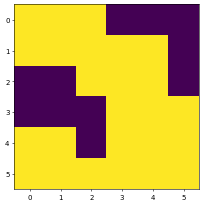

In [24]:
env.render()

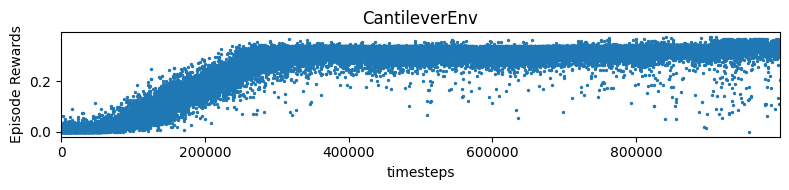

In [25]:
results_plotter.plot_results([log_dir], ts, results_plotter.X_TIMESTEPS, "CantileverEnv")

In [26]:
obs=env.reset()[0]

In [27]:
# Load the agent
model_best = PPO.load(log_dir + "best_model.zip",env=env)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_mode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_mode` for environment variables or `env.get_wrapper_attr('render_mode')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:74: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  try:


In [28]:
i=0
while i<1000:
    action, _states = model_best.predict(obs)
    
    obs, rewards, dones, _,info = env.step(int(action))
    if dones:
        break
    i+=1

In [29]:
i

36


Final Cantilever beam design:


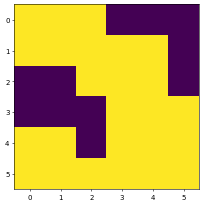

In [30]:
env.render()

In [31]:
# TODO - https://www.sciencedirect.com/science/article/pii/S0264127522002933

# 6 by 6 grid
# different reward 3 
# training ~1.5 hr

# illegal moves reward = -1, terminate ? 

# CNN
# randomize loads 
# utilize symmetry
# reward at the end of episode
# action - remove elements not add 
# refinement 6x6 -> 12x12
# load two elements in inference - test generalizability
# input stress field instead of density field 
# test different RL algorithms 